<a href="https://colab.research.google.com/github/Talha-Bicak/airlinePassengers_RNN/blob/main/airPassengr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler

import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

# Model değelendirme ve veriyi scale edebilmeniz için kullanılacak olan kütüphaneler

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Model için kullanılacak olan  kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Warningleri Kapatmak için kullanılacak kütüphaneler
import warnings
warnings.filterwarnings('ignore')

#TensorFlow warnings Engelleme
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
dir_path = '/content/drive/MyDrive/airlinePassenger/international-airline-passengers.csv'

In [4]:
df = pd.read_csv(dir_path)

In [5]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [6]:
df.columns = ['Month', 'Passenger']

In [7]:
df.head()

,Month,Passenger
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [8]:
df.isnull().sum()

Month        0
Passenger    1
dtype: int64

In [9]:
df.shape

(145, 2)

In [10]:
df.dtypes

Month         object
Passenger    float64
dtype: object

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passenger,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [12]:
df.tail()

,Month,Passenger
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [13]:
df = df[:144] #Nan olan son satırdan kurtulma

In [14]:
df.tail()

,Month,Passenger
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [15]:
df.info() #Verimizde kategorik bir değişken bulunmakta

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Month      144 non-null    object 
 1   Passenger  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [16]:
df["Month"] = pd.to_datetime(df["Month"]) #Kategorik değişkeni uygun standartlara getirme

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Month      144 non-null    datetime64[ns]
 1   Passenger  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [18]:
print("Minimum Tarih: " , df["Month"].min())
print("Maximum Tarih: " , df["Month"].max())

Minimum Tarih:  1949-01-01 00:00:00
Maximum Tarih:  1960-12-01 00:00:00


In [19]:
df.index = df["Month"]

In [20]:
df.drop("Month",axis=1,inplace=True)

In [21]:
result_df = df.copy()

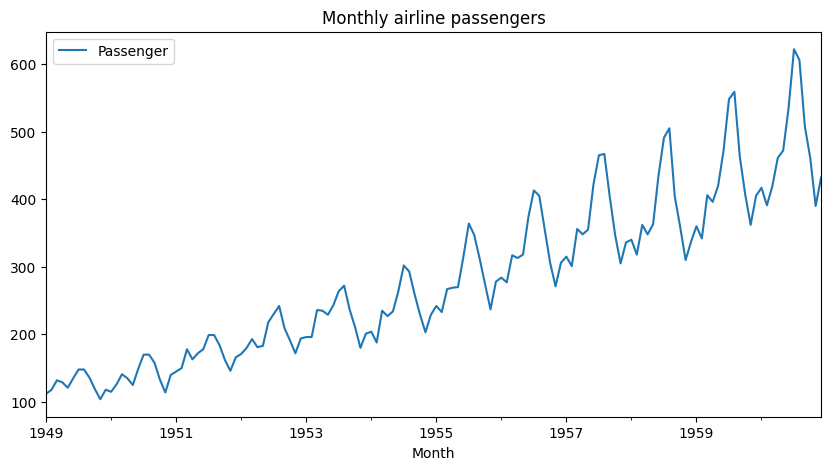

In [22]:
df.plot(figsize=(10,5),title= "Monthly airline passengers");

In [23]:
data = df["Passenger"].values

In [24]:
data[:5]

array([112., 118., 132., 129., 121.])

In [25]:
type(data[0]) # Veri setinin içerisindeki elemanın tipine bakıyoruz.

numpy.float64

In [26]:
data = data.astype('float32') #Her bir elemanın tipini float32'e çeviriyoruz.

In [27]:
type(data[0])

numpy.float32

In [28]:
data.shape

(144,)

In [29]:
data = data.reshape(-1,1)

In [30]:
data.shape

(144, 1)

In [31]:
# Üzerinde çalıştığımız veri seti bir zaman serisi olduğundan ötürü kontrollü bir biçimde ayırma işlemini yapmamız gerekiyor.
def split_data(dataframe , test_size):
  position = int(round(len(dataframe) * (1-test_size)))
  train = dataframe[:position]
  test = dataframe[position:]
  return train , test, position

In [32]:
train, test, position = split_data(data, 0.33)

In [33]:
print(train.shape, test.shape)

(96, 1) (48, 1)


In [34]:
sc_train = MinMaxScaler(feature_range = (0,1))
train = sc_train.fit_transform(train)

In [35]:
sc_test = MinMaxScaler(feature_range = (0,1))
test = sc_test.fit_transform(test)

In [36]:
print(train[:5], "\n  -----------\n",test[:5])

[[0.02588999]
 [0.04530746]
 [0.09061491]
 [0.08090615]
 [0.05501619]] 
  -----------
 [[0.04361373]
 [0.        ]
 [0.17133951]
 [0.1464175 ]
 [0.16822433]]


In [37]:
#Bir önceki adıma gidip işlemler yapılması için kullanılacak olan fonksiyon
def create_features(data, lookback):
  X, Y = [] , []
  for i in range(lookback, len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])
  return np.array(X) , np.array(Y)

In [38]:
lookback = 1

In [39]:
#Train Veri Seti
X_train , y_train =create_features(train, lookback)

In [40]:
# Test Veri Seti
X_test, y_test = create_features(test, lookback)

In [41]:
print(X_train.shape,y_train.shape, X_test.shape, y_test.shape)

(95, 1) (95,) (47, 1) (47,)


In [42]:
# Veri setini RNN nin istediği formata getirme
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [43]:
print(X_train.shape,y_train.shape, X_test.shape, y_test.shape) #Boyut arttırma işlemi uygulanmış

(95, 1, 1) (95, 1) (47, 1, 1) (47, 1)


In [44]:
model = Sequential()

model.add(SimpleRNN(units = 50,
                    activation = 'relu',
                    input_shape=(X_train.shape[1], lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
model.compile(loss='mean_squared_error', optimizer = 'adam')

In [47]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode =  "min"),
            ModelCheckpoint(filepath = 'mymodel.h5', monitor = 'val_loss', mode = 'min', save_best_only= True, save_weights_only=False)]


In [48]:
history = model.fit(X_train, y_train, epochs= 50, batch_size=1, validation_data = (X_test, y_test), callbacks = callbacks, shuffle = False)

Epoch 1/50
95/95 [==============================] - 2s 7ms/step - loss: 0.0133 - val_loss: 0.0352
Epoch 2/50
95/95 [==============================] - 0s 4ms/step - loss: 0.0222 - val_loss: 0.0230
Epoch 3/50
95/95 [==============================] - 0s 4ms/step - loss: 0.0130 - val_loss: 0.0219
Epoch 4/50
95/95 [==============================] - 0s 4ms/step - loss: 0.0110 - val_loss: 0.0214
Epoch 5/50
95/95 [==============================] - 0s 5ms/step - loss: 0.0112 - val_loss: 0.0230
Epoch 6/50
95/95 [==============================] - 0s 4ms/step - loss: 0.0141 - val_loss: 0.0218
Epoch 7/50
95/95 [==============================] - 0s 5ms/step - loss: 0.0081 - val_loss: 0.0217
Epoch 7: early stopping


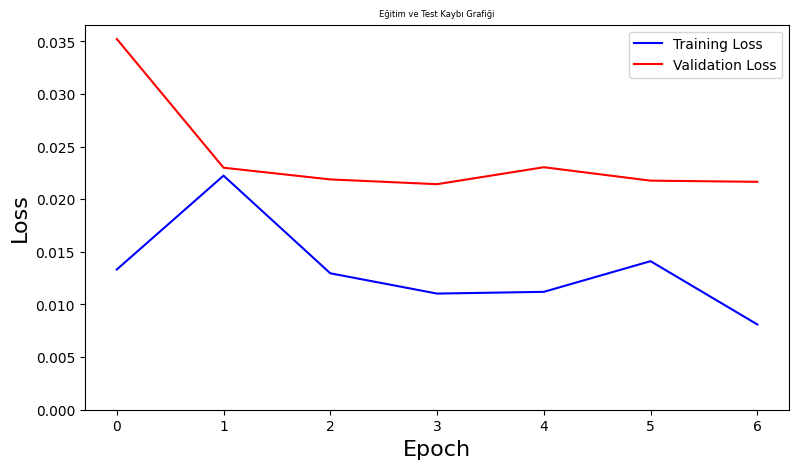

In [49]:
plt.figure(figsize= (20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], color='b', label='Training Loss')
plt.plot(history.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize= 16)
plt.ylabel('Loss', fontsize= 16)
plt.ylim([0,max(plt.ylim())])
plt.title('Eğitim ve Test Kaybı Grafiği', fontsize=6)
plt.show()

In [50]:
loss = model.evaluate(X_test, y_test, batch_size = 1)
print("\nTest Loss: %1.f%%" % (100.0 * loss))

47/47 [==============================] - 0s 4ms/step - loss: 0.0217

Test Loss: 2%


In [51]:
train_predict = model.predict(X_train)

3/3 [==============================] - 0s 7ms/step


In [52]:
test_predict = model.predict(X_test)

2/2 [==============================] - 0s 8ms/step


In [54]:
train_predict = sc_train.inverse_transform(train_predict)
test_predict = sc_test.inverse_transform(test_predict)

In [55]:
y_train = sc_train.inverse_transform(y_train)
y_test = sc_test.inverse_transform(y_test)

In [56]:
# Train veri setine ait Root Mean Squared Error değeri
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [58]:
# Test veri setine ait Root Mean Squared Error değeri
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [60]:
print(f"Train Veri Setine Ait RMSE Değeri: {train_rmse}")
print(f"Test Veri Setine Ait RMSE Değeri: {test_rmse}")

Train Veri Setine Ait RMSE Değeri: 24.1428165435791
Test Veri Setine Ait RMSE Değeri: 47.24045181274414


In [61]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passenger,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [64]:
train_prediction_df = result_df[lookback:position]

In [65]:
train_prediction_df["Predicted"] = train_predict

In [66]:
train_prediction_df.head()

,Passenger,Predicted
Month,,
1949-02-01,118.0,130.697083
1949-03-01,132.0,135.015457
1949-04-01,129.0,147.863968
1949-05-01,121.0,145.110718
1949-06-01,135.0,137.768707


In [67]:
test_prediction_df = result_df[position + lookback:]
test_prediction_df["Predicted"] = test_predict
test_prediction_df.head()

,Passenger,Predicted
Month,,
1957-02-01,301.0,332.720978
1957-03-01,356.0,323.772614
1957-04-01,348.0,370.348755
1957-05-01,355.0,363.006775
1957-06-01,422.0,369.431030


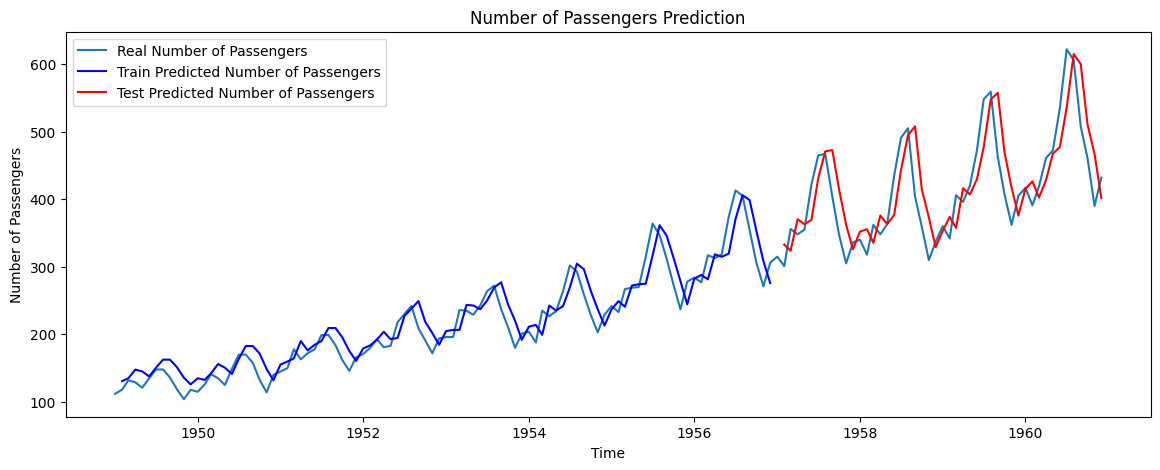

In [69]:
# Train ve Test Tahminlerini ayrı ayrı görselleştirme işlemi
plt.figure(figsize=(14,5))
plt.plot(result_df, label = 'Real Number of Passengers')
plt.plot(train_prediction_df["Predicted"], color = 'blue', label = 'Train Predicted Number of Passengers')
plt.plot(test_prediction_df["Predicted"], color = "red", label = 'Test Predicted Number of Passengers')
plt.title('Number of Passengers Prediction')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()